# Convolutional Neural Network for Anime Image Classification

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image

## Load the Data

In [2]:
import io
import requests

def load_images_from_zip(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        images = {'anastasia': [], 'takao': []}
        for file_name in zip_ref.namelist():
            if file_name.startswith('anastasia') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['anastasia'].append(np.array(img))
            elif file_name.startswith('takao') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['takao'].append(np.array(img))
    return images

zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/xZQHOyN8ONT92kH-ASb4Pw/data.zip'

# Download the ZIP file
response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)

# Load images from zip file
images = load_images_from_zip(zip_file_bytes)

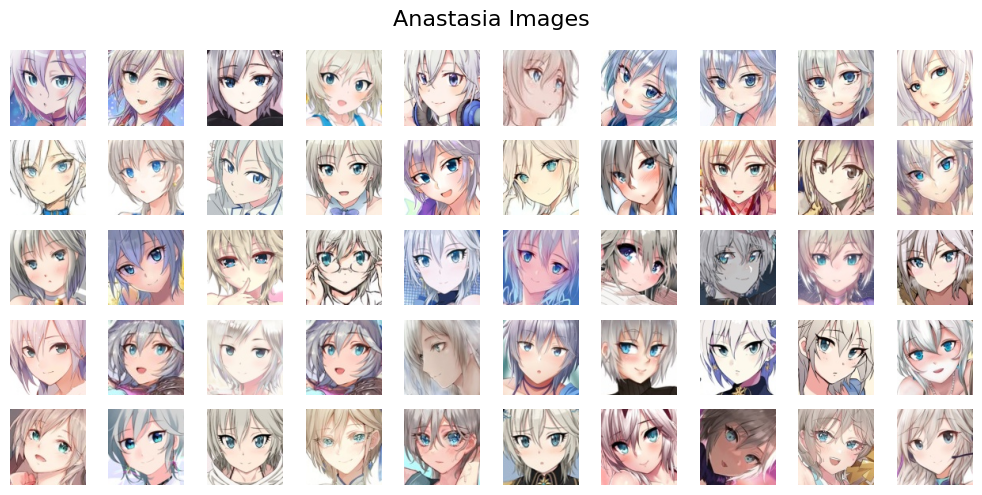

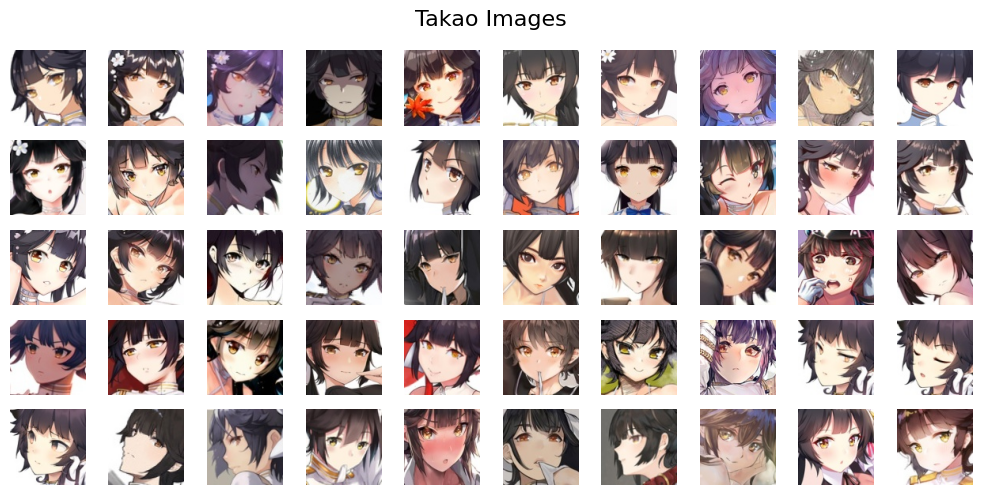

In [3]:
def plot_images(images, title):
    fig, axes = plt.subplots(5, 10, figsize=(10, 5))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot images from 'anastasia'
plot_images(images['anastasia'], 'Anastasia Images')

# Plot images from 'takao'
plot_images(images['takao'], 'Takao Images')

In [4]:
print("Number of images of Anastasia:", len(images['anastasia']))
print("Number of images of Takao:", len(images['takao']))

Number of images of Anastasia: 50
Number of images of Takao: 50


### Custom Dataset Class

In [5]:
class AnimeDataset(Dataset):
    def __init__(self, images, transform=None, classes=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.classes = classes

        for label, class_name in enumerate(self.classes):
            for img in images[class_name]:
                self.images.append(img)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
dataset = AnimeDataset(images, transform=transform, classes=['anastasia', 'takao'])


## Split Dataset

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Generate a list of indices for the entire dataset
indices = list(range(len(dataset)))

# Split the indices into training and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)

# Create samplers for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create DataLoader objects for training and validation sets
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=20, sampler=val_sampler)

# Print the sizes of the training and validation sets
print("Train size:", len(train_indices))
print("Validation size:", len(val_indices))

Train size: 80
Validation size: 20


## CNN Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class AnimeCNN(nn.Module):
    def __init__(self):
        super(AnimeCNN, self).__init__()
        # Add padding=1 to maintain the border
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = AnimeCNN()

In [8]:
print(model)

AnimeCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [9]:
input_tensor = torch.randn(1, 3, 64, 64)

def print_size(module, input, output):
    print(f"{module.__class__.__name__} output size: {output.size()}")

# Register hooks
hooks = []
for layer in model.children():
    hook = layer.register_forward_hook(print_size)
    hooks.append(hook)

# Inspect output sizes
with torch.no_grad():
    output = model(input_tensor)
print("Final output size:", output.size())

# Remove hooks
for hook in hooks:
    hook.remove()

Conv2d output size: torch.Size([1, 32, 64, 64])
MaxPool2d output size: torch.Size([1, 32, 32, 32])
Conv2d output size: torch.Size([1, 64, 32, 32])
MaxPool2d output size: torch.Size([1, 64, 16, 16])
Linear output size: torch.Size([1, 128])
Linear output size: torch.Size([1, 2])
Final output size: torch.Size([1, 2])


In [10]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train the Model

In [11]:
import matplotlib.pyplot as plt
import torch

# Training loop
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')

Epoch 1, Train Loss: 0.7333, Val Loss: 0.1828
Epoch 2, Train Loss: 0.1857, Val Loss: 0.0011
Epoch 3, Train Loss: 0.0471, Val Loss: 0.0005
Epoch 4, Train Loss: 0.0086, Val Loss: 0.0003
Epoch 5, Train Loss: 0.0009, Val Loss: 0.0002
Finished Training


## Visualize the Training and Test Loss

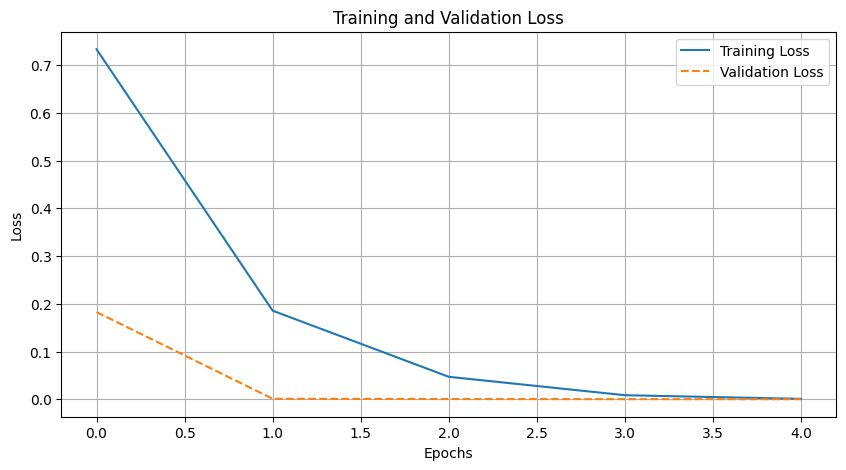

In [12]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()


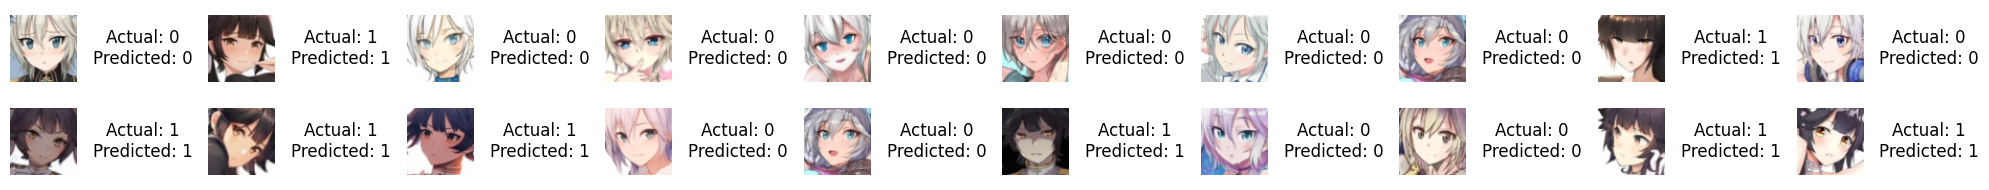

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to display an image
def imshow(img, ax):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose dimensions to match matplotlib's expected format
    ax.axis('off')

# Set model to evaluation mode
model.eval()

data_iter = iter(val_loader)
images, labels = next(data_iter)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Define the grid size
num_images = len(images)
num_cols = 10
num_rows = 2

fig, axs = plt.subplots(num_rows, num_cols * 2, figsize=(20, num_rows))

for idx in range(num_images):
    row = idx // num_cols
    col = (idx % num_cols) * 2

    # Plot the image
    imshow(images[idx].cpu(), axs[row, col])

    # Display actual and predicted labels
    axs[row, col + 1].text(0.5, 0.5, f"Actual: {labels[idx].item()}\nPredicted: {predicted[idx].item()}",
                           horizontalalignment='center', verticalalignment='center', fontsize=12)
    axs[row, col + 1].axis('off')

# Turn off any remaining empty subplots
for idx in range(num_images, num_rows * num_cols):
    row = idx // num_cols
    col = (idx % num_cols) * 2
    axs[row, col].axis('off')
    axs[row, col + 1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
correct = 0
total = 0

# Compute overall accuracy
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f'correct: {correct}, total: {total}')

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

correct: 20, total: 20
Validation Accuracy: 100.00%


## Use different character classes

Number of images of arcueid_brunestud: 50
Number of images of yukinoshita_yukino: 50


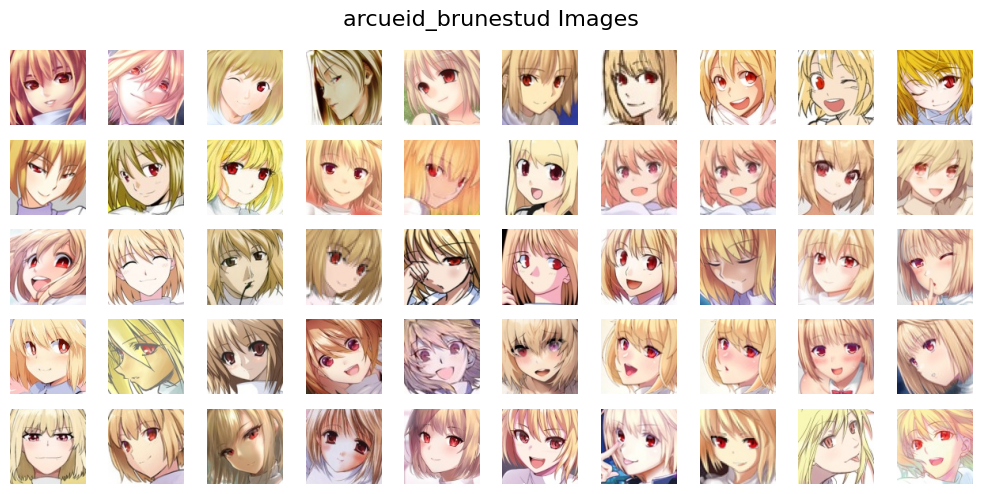

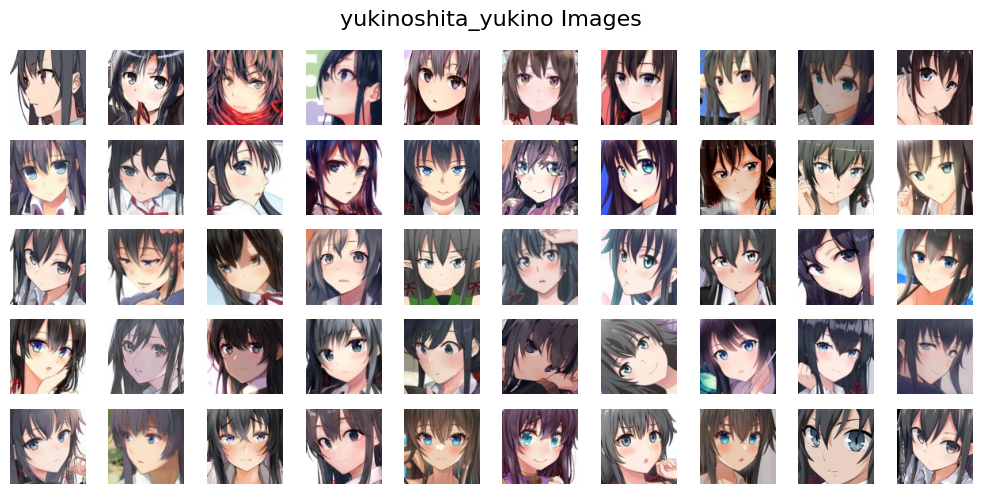

In [15]:
def load_images_from_zip(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        images = {'arcueid_brunestud': [], 'yukinoshita_yukino': []}
        for file_name in zip_ref.namelist():
            if file_name.startswith('arcueid_brunestud') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['arcueid_brunestud'].append(np.array(img))
            elif file_name.startswith('yukinoshita_yukino') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['yukinoshita_yukino'].append(np.array(img))
    return images

zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/yNB99OssvDWOrNTHf2Yuxw/data-practice.zip'

# Download the ZIP file
response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)

# Load images from zip file
images = load_images_from_zip(zip_file_bytes)

print("Number of images of arcueid_brunestud:", len(images['arcueid_brunestud']))
print("Number of images of yukinoshita_yukino:", len(images['yukinoshita_yukino']))

# Plot images from 'arcueid_brunestud'
plot_images(images['arcueid_brunestud'], 'arcueid_brunestud Images')

# Plot images from 'yukinoshita_yukino'
plot_images(images['yukinoshita_yukino'], 'yukinoshita_yukino Images')

In [16]:
dataset = AnimeDataset(images, transform=transform, classes=['arcueid_brunestud', 'yukinoshita_yukino'])

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
indices = list(range(len(dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=20, sampler=val_sampler)

In [17]:
new_model = AnimeCNN()
optimizer = optim.Adam(new_model.parameters(), lr=0.001)
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    new_model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = new_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    new_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')

Epoch 1, Train Loss: 0.2565, Val Loss: 0.0003
Epoch 2, Train Loss: 0.0568, Val Loss: 0.0202
Epoch 3, Train Loss: 0.0342, Val Loss: 0.0020
Epoch 4, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 5, Train Loss: 0.0002, Val Loss: 0.0000
Finished Training


correct: 20, total: 20
Validation Accuracy: 100.00%


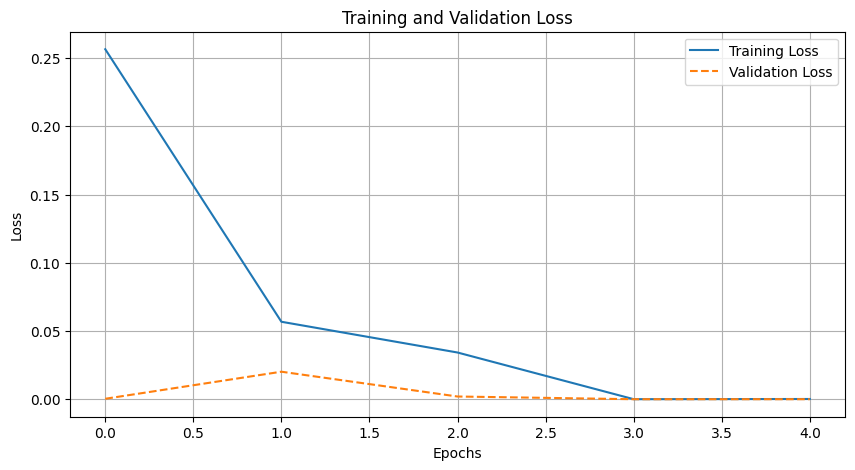

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f'correct: {correct}, total: {total}')

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()